In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
import matplotlib.patches as mpatches
import cmocean

import glob
from matplotlib import ticker


import sys
sys.path.append('../')
import utils
import plotting

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

In [7]:
import string
alphabet = list(string.ascii_lowercase)

# Import Data

### Load in GEOS Chem Runs made from File Creation Notebook, Load in HEMCO Emissions Files

In [2]:
ds= xr.open_dataset('./final_data/ds_PM_O3_daily.nc4')
ds_o3 = xr.open_dataset('./final_data/ds_O3_mda8.nc4')



In [3]:
#rename ozone and convert to ppb
ds_o3 = ds_o3.rename({'SpeciesConc_O3':'O3'})['O3']


In [4]:
ds.where(ds.time == (slice('2016-04-01','2016-09-30')))['O3'] = ds_o3

In [5]:
#create seasonal averages-- summer ozone is 8 hour afternoon maximum, winter ozone is daily, pm is daily
ds_seasonal = utils.season_mean(ds)
ds_seasonal = ds_seasonal


#combine the two datasets
ds_seasonal['PM25'].attrs = {'units':r'$u$g/m3'}
ds_seasonal['O3'].attrs = {'units':'ppb'}

#list of model names
model_names = ds['model_name'].values


## Mask data to US

In [6]:
#### create a mask ####
states = regionmask.defined_regions.natural_earth.us_states_50
lon = np.arange(230, 300, .25)
lat = np.arange(50, 24, -.125)
mask = states.mask(ds_seasonal, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask) & (mask != 0.) & (mask != 11) 

#### mask our population dataset ####
ds_seasonal = ds_seasonal.where(contiguous_mask)


# Plots

## US, concentrations

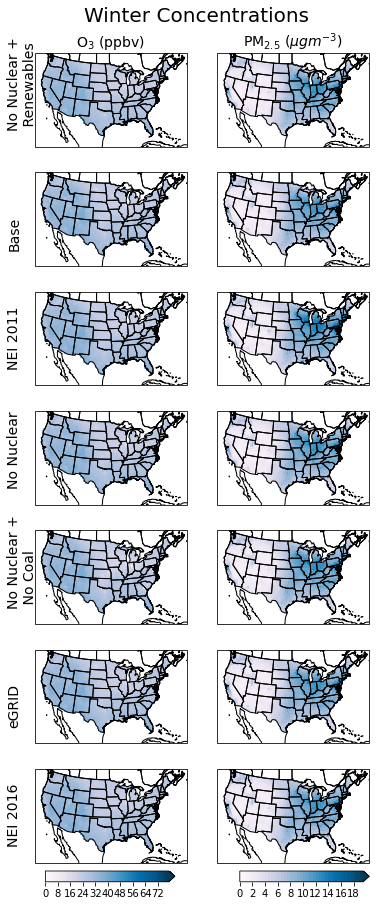

In [8]:
plotting.concentration_plot_seasonal(ds_seasonal = ds_seasonal, species_names = ['O3','PM25'], season = 'DJF', 
                                     model_names = model_names,  cmap = plotting.cmap_conc,
                        lat_lon = [-120,-70,20,50], shrink_cbar = 1,
                       figsize = [6,15])
plt.suptitle('Winter Concentrations', y = .92, fontsize = 20);
plt.savefig('./Figures/winter_summer_conc.png',bbox_inches = 'tight', dpi = 150)

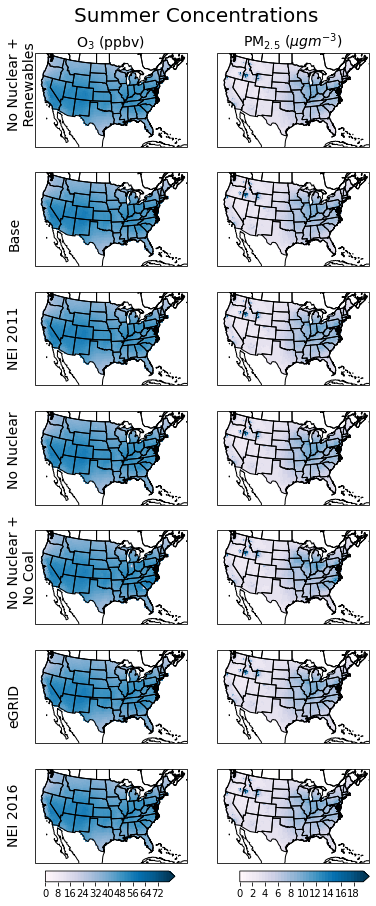

In [16]:
plotting.concentration_plot_seasonal(ds_seasonal = ds_seasonal, species_names = ['O3','PM25'], season = 'JJA', model_names = model_names,  cmap = plotting.cmap_conc,
                        lat_lon = [-120,-70,20,50], shrink_cbar = 1,
                       figsize = [6,15])
plt.suptitle('Summer Concentrations', y = .92, fontsize = 20);
plt.savefig('./Figures/summer_conc.png',bbox_inches = 'tight', dpi = 150)

## Combined summer and winter concentrations

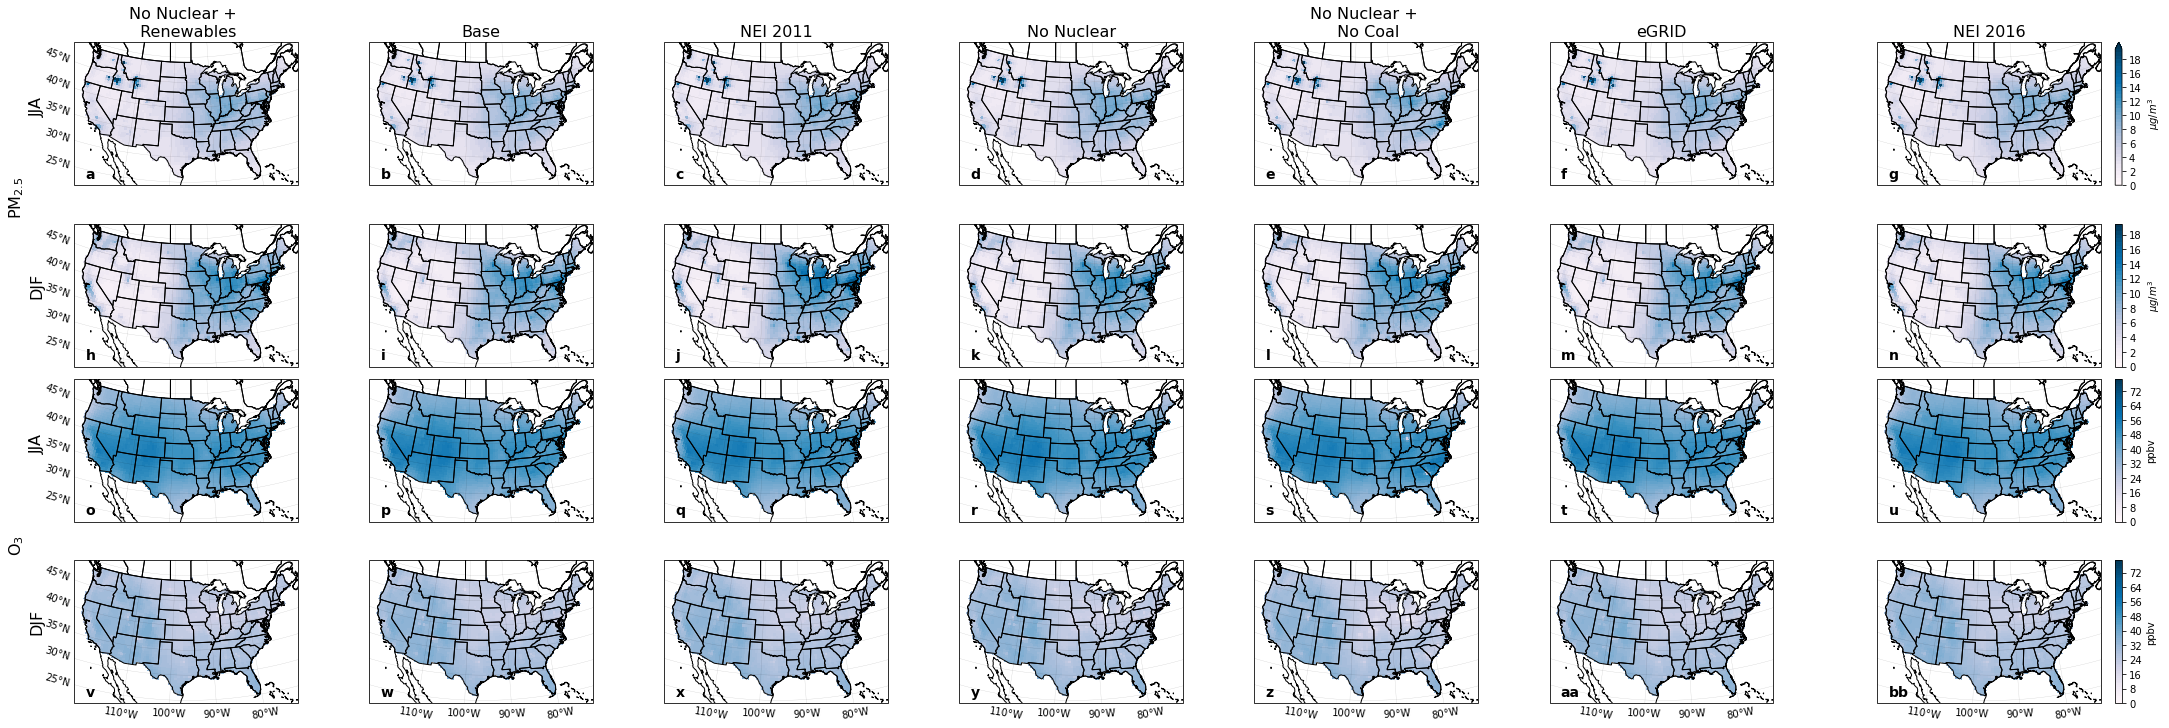

In [13]:
s = 'JJA'
fig = plt.figure(figsize = [30, 10], constrained_layout = True)
alpha_labels = iter(alphabet + ['aa','bb', 'cc','dd','ee'])
cbar_kwargs = {True:{'label':'$\mu g/m^3$'}, False: None}  
for idx, m in enumerate(ds_seasonal.model_name.values):
    if idx ==6:
        cbar_arg = True
    else:
        cbar_arg = False
    ax=fig.add_subplot(4,7,idx+1, projection=ccrs.LambertConformal())
    ds_seasonal.sel(season = s, model_name = m)['PM25'].plot(ax = ax, 
                                   levels = plotting.levels_dict['PM25'],
                                     cmap = plotting.cmap_conc, 
                                    transform=ccrs.PlateCarree(),
                                        add_colorbar = cbar_arg, cbar_kwargs = cbar_kwargs[cbar_arg])
    ax.add_feature(cfeat.STATES)
    ax.coastlines() #add coastlines
    ax.set_title(plotting.proper_model_names_dict[m], fontsize = 16)
    if idx == 0:
        ax.text(-0.3, -0.2, r'PM$_{2.5}$', rotation = 'vertical', fontsize = 16, transform=ax.transAxes)
    if idx == 0:
        ax.text(-0.2, 0.5, s = s, rotation = 'vertical', fontsize = 16, transform=ax.transAxes)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
    if idx == 0:
        gl.right_labels = gl.top_labels = gl.bottom_labels = False
    else:
        gl.right_labels = gl.top_labels = gl.bottom_labels = gl.left_labels = False 
    gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])
    ax.set_extent(plotting.lat_lon)
    label = next(alpha_labels)
    ax.text(x = .05, y =.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
    
s = 'DJF'
for idx, m in enumerate(ds_seasonal.model_name.values):
    if idx ==6:
        cbar_arg = True
    else:
        cbar_arg = False
    ax=fig.add_subplot(4,7,idx+8, projection=ccrs.LambertConformal())
    ds_seasonal.sel(season = s, model_name = m)['PM25'].plot(ax = ax, 
                                   levels = plotting.levels_dict['PM25'],
                                     cmap = plotting.cmap_conc, 
                                    transform=ccrs.PlateCarree(),
                                        add_colorbar = cbar_arg, cbar_kwargs = cbar_kwargs[cbar_arg])
    ax.add_feature(cfeat.STATES)
    ax.coastlines() #add coastlines
    ax.set_title(None)
    if idx == 0:
        ax.text(-0.2, 0.5, s = s, rotation = 'vertical', fontsize = 16, transform=ax.transAxes)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
    if idx == 0:
        gl.right_labels = gl.top_labels = gl.bottom_labels = False
    else:
        gl.right_labels = gl.top_labels = gl.bottom_labels = gl.left_labels = False

    gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])
    ax.set_extent(plotting.lat_lon)
    label = next(alpha_labels)
    ax.text(x = .05, y =.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
    
s = 'JJA'
cbar_kwargs = {True:{'label':'ppbv'}, False: None}  
for idx, m in enumerate(ds_seasonal.model_name.values):
    if idx ==6:
        cbar_arg = True
    else:
        cbar_arg = False    
    ax=fig.add_subplot(4,7,idx+7*2+1, projection=ccrs.LambertConformal())
    ds_seasonal.sel(season = s, model_name = m)['O3'].plot(ax = ax, 
                                   levels = plotting.levels_dict['O3'],
                                     cmap = plotting.cmap_conc, 
                                    transform=ccrs.PlateCarree(),
                                        add_colorbar = cbar_arg, cbar_kwargs = cbar_kwargs[cbar_arg])
    ax.add_feature(cfeat.STATES)
    ax.coastlines() #add coastlines
    ax.set_extent([-120,-70,20,50]) 
    ax.set_title(None)
    if idx == 0:
        ax.text(-0.3, -0.2, r'O$_3$', rotation = 'vertical', fontsize = 16, transform=ax.transAxes)
    if idx == 0:
        ax.text(-0.2, 0.5, s = s, rotation = 'vertical', fontsize = 16, transform=ax.transAxes)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
    if idx == 0:
        gl.right_labels = gl.top_labels = gl.bottom_labels = False
    else:
        gl.right_labels = gl.top_labels = gl.bottom_labels = gl.left_labels = False
    gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])
    ax.set_extent(plotting.lat_lon)
    label = next(alpha_labels)
    ax.text(x = .05, y =.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
    
s = 'DJF'
for idx, m in enumerate(ds_seasonal.model_name.values):
    if idx ==6:
        cbar_arg = True
    else:
        cbar_arg = False    
    ax=fig.add_subplot(4,7,idx+7*3+1, projection=ccrs.LambertConformal())
    ds_seasonal.sel(season = s, model_name = m)['O3'].plot(ax = ax, 
                                   levels = plotting.levels_dict['O3'],
                                     cmap = plotting.cmap_conc, 
                                    transform=ccrs.PlateCarree(),
                                        add_colorbar = cbar_arg, cbar_kwargs = cbar_kwargs[cbar_arg])
    
    
    ax.add_feature(cfeat.STATES)
    ax.coastlines() #add coastlines
    ax.set_title(None)
    if idx == 0:
        ax.text(-0.2, 0.5, s = s, rotation = 'vertical', fontsize = 16, transform=ax.transAxes)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
    if idx == 0:
        gl.right_labels = gl.top_labels = False
    else: 
        gl.right_labels = gl.top_labels = gl.left_labels = False
    gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])
    ax.set_extent(plotting.lat_lon)
    label = next(alpha_labels)
    ax.text(x = .05, y =.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
    
plt.savefig('Figures/supplement/pm_o3_conc.png', bbox_inches = 'tight', dpi = 300)

## Differences by scenario

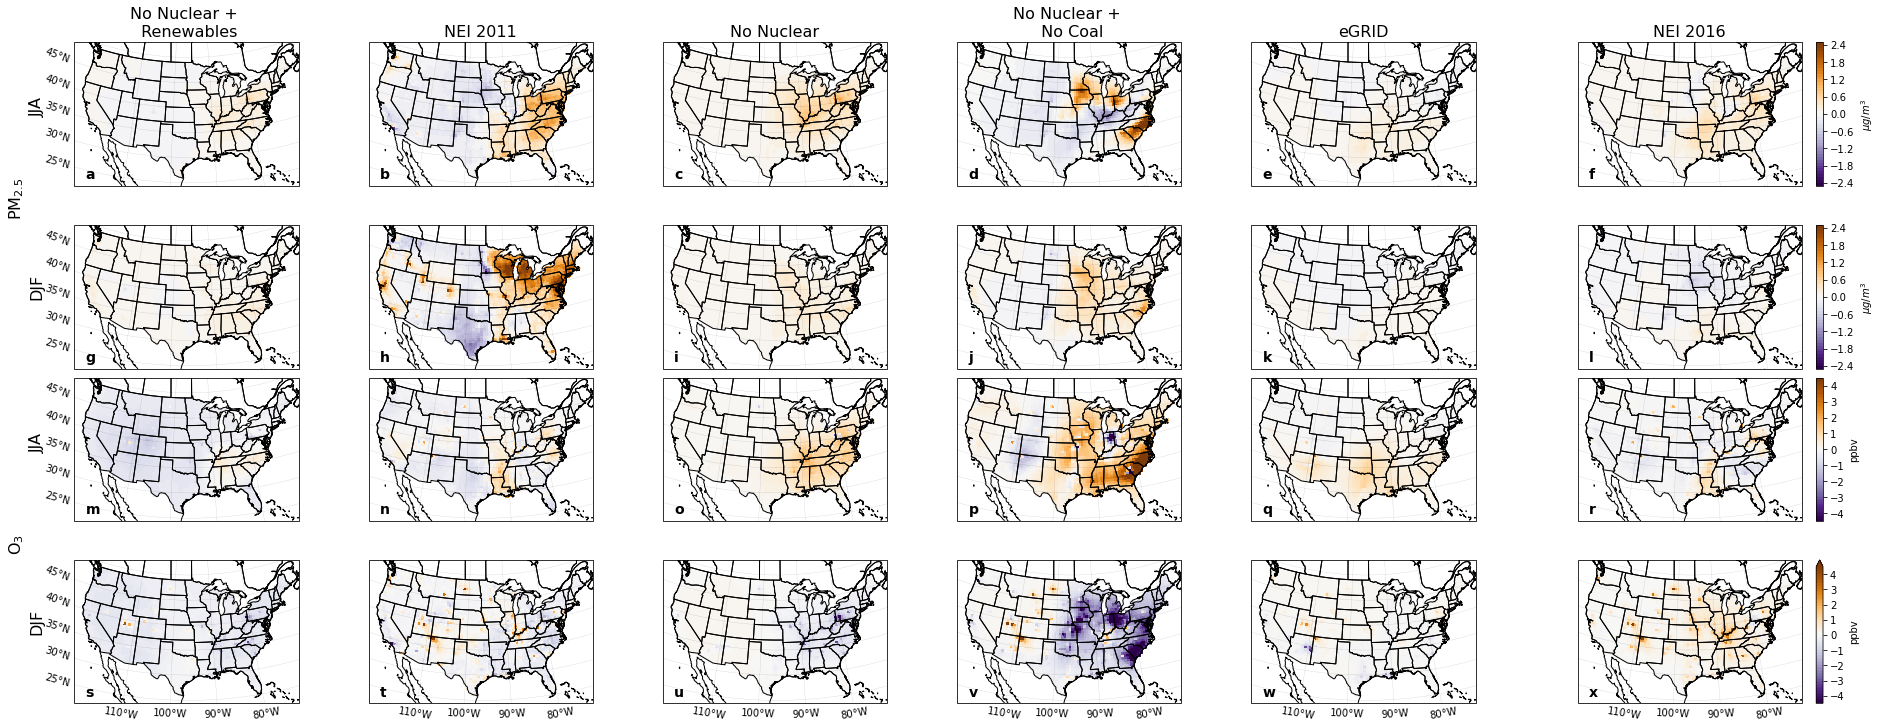

In [14]:
s = 'JJA'
fig = plt.figure(figsize = [26, 10], constrained_layout = True)
cbar_kwargs = {True:{'label':'$\mu g/m^3$'}, False: None}  
alpha_labels = iter(alphabet + ['aa','bb', 'cc','dd','ee'])
for idx, m in enumerate(['renew_nonuc_NA', 'nei_NA', 'nonuc_NA',
       'nonuc_coal_NA', 'egrid_NA', 'epa_NA']):
    if idx ==5:
        cbar_arg = True
    else:
        cbar_arg = False
    ax=fig.add_subplot(4,6,idx+1, projection=ccrs.LambertConformal())
    (ds_seasonal.sel(model_name = m)-ds_seasonal.sel(model_name = 'normal_NA')).sel(season = s)['PM25'].plot(ax = ax, 
                                   levels = np.arange(-2.5,2.6,.1),
                                     cmap = 'PuOr_r', 
                                    transform=ccrs.PlateCarree(),
                                        add_colorbar = cbar_arg, cbar_kwargs = cbar_kwargs[cbar_arg])
    ax.add_feature(cfeat.STATES)
    ax.coastlines() #add coastlines
    ax.set_title(plotting.proper_model_names_dict[m], fontsize = 16)
    if idx == 0:
        ax.text(-0.3, -0.2, r'PM$_{2.5}$', rotation = 'vertical', fontsize = 16, transform=ax.transAxes)
    if idx == 0:
        ax.text(-0.2, 0.5, s = s, rotation = 'vertical', fontsize = 16, transform=ax.transAxes)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
    if idx == 0:
        gl.right_labels = gl.top_labels = gl.bottom_labels = False
    else:
        gl.right_labels = gl.top_labels = gl.bottom_labels = gl.left_labels = False 
    gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])
    ax.set_extent(plotting.lat_lon)
    label = next(alpha_labels)
    ax.text(x = .05, y =.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
        
s = 'DJF'
for idx, m in enumerate(['renew_nonuc_NA', 'nei_NA', 'nonuc_NA',
       'nonuc_coal_NA', 'egrid_NA', 'epa_NA']):
    if idx ==5:
        cbar_arg = True
    else:
        cbar_arg = False
    ax=fig.add_subplot(4,6,idx+7, projection=ccrs.LambertConformal())
    (ds_seasonal.sel(model_name = m)-ds_seasonal.sel(model_name = 'normal_NA')).sel(season = s)['PM25'].plot(ax = ax, 
                                   levels = np.arange(-2.5,2.6,.1),
                                     cmap = 'PuOr_r', 
                                    transform=ccrs.PlateCarree(),
                                        add_colorbar = cbar_arg, cbar_kwargs = cbar_kwargs[cbar_arg])
    ax.add_feature(cfeat.STATES)
    ax.coastlines() #add coastlines
    ax.set_title(None)
    if idx == 0:
        ax.text(-0.2, 0.5, s = s, rotation = 'vertical', fontsize = 16, transform=ax.transAxes)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
    if idx == 0:
        gl.right_labels = gl.top_labels = gl.bottom_labels = False
    else:
        gl.right_labels = gl.top_labels = gl.bottom_labels = gl.left_labels = False

    gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])
    ax.set_extent(plotting.lat_lon)
    label = next(alpha_labels)
    ax.text(x = .05, y =.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
    
s = 'JJA'
cbar_kwargs = {True:{'label':'ppbv'}, False: None}  
for idx, m in enumerate(['renew_nonuc_NA', 'nei_NA', 'nonuc_NA',
       'nonuc_coal_NA', 'egrid_NA', 'epa_NA']):
    if idx ==5:
        cbar_arg = True
    else:
        cbar_arg = False    
    ax=fig.add_subplot(4,6,idx+6*2+1, projection=ccrs.LambertConformal())
    (ds_seasonal.sel(model_name = m)-ds_seasonal.sel(model_name = 'normal_NA')).sel(season = s)['O3'].plot(ax = ax, 
                                   levels = np.arange(-4.5,4.6,.1),
                                     cmap = 'PuOr_r', 
                                    transform=ccrs.PlateCarree(),
                                        add_colorbar = cbar_arg, cbar_kwargs = cbar_kwargs[cbar_arg])
    ax.add_feature(cfeat.STATES)
    ax.coastlines() #add coastlines
    ax.set_extent([-120,-70,20,50]) 
    ax.set_title(None)
    if idx == 0:
        ax.text(-0.3, -0.2, r'O$_3$', rotation = 'vertical', fontsize = 16, transform=ax.transAxes)
    if idx == 0:
        ax.text(-0.2, 0.5, s = s, rotation = 'vertical', fontsize = 16, transform=ax.transAxes)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
    if idx == 0:
        gl.right_labels = gl.top_labels = gl.bottom_labels = False
    else:
        gl.right_labels = gl.top_labels = gl.bottom_labels = gl.left_labels = False
    gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])
    ax.set_extent(plotting.lat_lon)
    label = next(alpha_labels)
    ax.text(x = .05, y =.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
        
s = 'DJF'
for idx, m in enumerate(['renew_nonuc_NA', 'nei_NA', 'nonuc_NA',
       'nonuc_coal_NA', 'egrid_NA', 'epa_NA']):
    if idx ==5:
        cbar_arg = True
    else:
        cbar_arg = False    
    ax=fig.add_subplot(4,6,idx+6*3+1, projection=ccrs.LambertConformal())
    (ds_seasonal.sel(model_name = m)-ds_seasonal.sel(model_name = 'normal_NA')).sel(season = s)['O3'].plot(ax = ax, 
                                   levels = np.arange(-4.5,4.6,.1),
                                     cmap = 'PuOr_r', 
                                    transform=ccrs.PlateCarree(),
                                        add_colorbar = cbar_arg, cbar_kwargs = cbar_kwargs[cbar_arg])
    
    
    ax.add_feature(cfeat.STATES)
    ax.coastlines() #add coastlines
    ax.set_title(None)
    if idx == 0:
        ax.text(-0.2, 0.5, s = s, rotation = 'vertical', fontsize = 16, transform=ax.transAxes)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
    if idx == 0:
        gl.right_labels = gl.top_labels = False
    else: 
        gl.right_labels = gl.top_labels = gl.left_labels = False
    gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])
    ax.set_extent(plotting.lat_lon)
    label = next(alpha_labels)
    ax.text(x = .05, y =.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
    
plt.savefig('Figures/supplement/pm_o3_season_dif.png', bbox_inches = 'tight', dpi = 300)

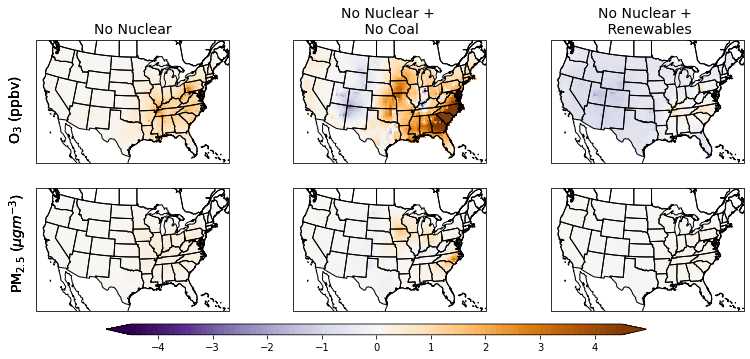

In [30]:
#PM2.5 png plot
plotting.concentration_plot_seasonal_dif_models(ds_seasonal_pm = ds_seasonal, ds_o3_winter_only = ds_o3, polls = ['O3','PM25'], cmap = 'PuOr_r', 
                                         mod_base = 'normal_NA', mod_deltas = ['nonuc_NA', 'nonuc_coal_NA','renew_nonuc_NA'],
                   rows = 2, columns = 3, levels = np.arange(-4.5,4.6,.1), lat_lon = plotting.lat_lon,
                   figsize = [15, 5], extension = 'both')
plt.savefig('./Figures/PM_O3_comparison.png', bbox_inches = 'tight', dpi = 300)

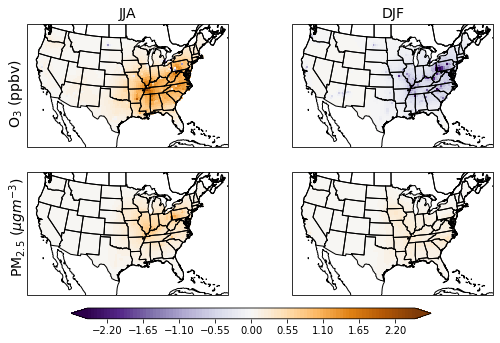

In [31]:
plotting.concentration_plot_seasonal_dif(ds_seasonal = ds_seasonal, seasons = ['JJA','DJF'], species_names = ['O3','PM25'], cmap = 'PuOr_r', 
                                         mod_base = 'normal_NA', mod_delta = 'nonuc_NA',
                   rows = 2, columns = 2, levels = np.arange(-2.5,2.55,.05), lat_lon = [-120,-70,20,50],
                   figsize = [10, 5], extension = 'both')
plt.savefig('./Figures/PM_O3_dif_nonuc.png', bbox_inches = 'tight', dpi = 150)

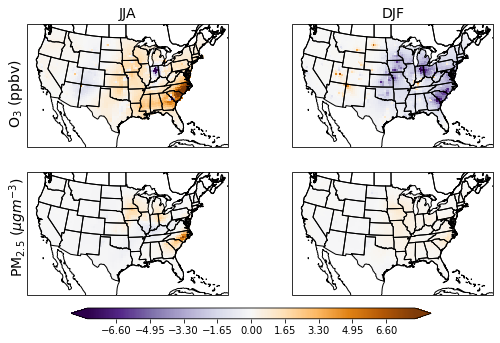

In [32]:
plotting.concentration_plot_seasonal_dif(ds_seasonal = ds_seasonal, seasons = ['JJA','DJF'], species_names = ['O3','PM25'], cmap = 'PuOr_r', 
                                         mod_base = 'normal_NA', mod_delta = 'nonuc_coal_NA',
                   rows = 2, columns = 2, levels = np.arange(-8,8.05,.05), lat_lon = [-120,-70,20,50],
                   figsize = [10, 5], extension = 'both')
plt.savefig('./Figures/PM_O3_dif_nocoal.png', bbox_inches = 'tight', dpi = 150)

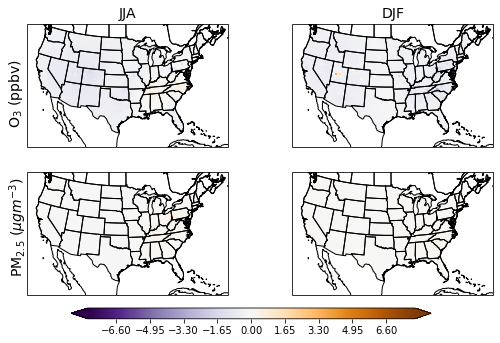

In [33]:
plotting.concentration_plot_seasonal_dif(ds_seasonal = ds_seasonal, seasons = ['JJA','DJF'], species_names = ['O3','PM25'], cmap = 'PuOr_r', 
                                         mod_base = 'normal_NA', mod_delta = 'renew_nonuc_NA',
                   rows = 2, columns = 2, levels = np.arange(-8,8.05,.05), lat_lon = [-120,-70,20,50],
                   figsize = [10, 5], extension = 'both')
plt.savefig('./Figures/PM_O3_dif_renew.png', bbox_inches = 'tight', dpi = 150)

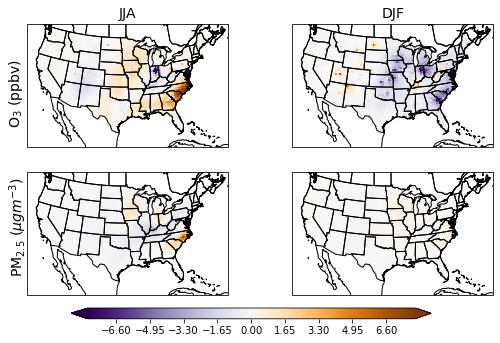

In [34]:
plotting.concentration_plot_seasonal_dif(ds_seasonal = ds_seasonal, seasons = ['JJA','DJF'], species_names = ['O3','PM25'], cmap = 'PuOr_r', 
                                         mod_base = 'nonuc_NA', mod_delta = 'nonuc_coal_NA',
                   rows = 2, columns = 2, levels = np.arange(-8,8.05,.05), lat_lon = [-120,-70,20,50],
                   figsize = [10, 5], extension = 'both')
plt.savefig('./Figures/PM_O3_dif_nocoal-nonuc.png', bbox_inches = 'tight', dpi = 150)

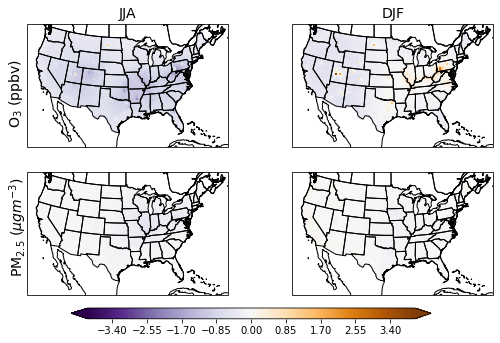

In [35]:
plotting.concentration_plot_seasonal_dif(ds_seasonal = ds_seasonal, seasons = ['JJA','DJF'], species_names = ['O3','PM25'], cmap = 'PuOr_r', 
                                         mod_base = 'nonuc_NA', mod_delta = 'renew_nonuc_NA',
                   rows = 2, columns = 2, levels = np.arange(-4,4.05,.05), lat_lon = [-120,-70,20,50],
                   figsize = [10, 5], extension = 'both')
plt.savefig('./Figures/PM_O3_dif_renew-nonuc.png', bbox_inches = 'tight', dpi = 150)